In [ ]:
!git clone https://github/Filmon97/voted-perceptron.git

# Change the working directory to the repo root.
%cd voted-perceptron

# Add the repo root to the Python path.
import sys, os
sys.path.append(os.getcwd())


In [ ]:
# install the packages
pip install -r requirements.txt

In [ ]:
# install the last version of numba
pip install --upgrade numba

Let's try if the mnist dataset is loaded correctly

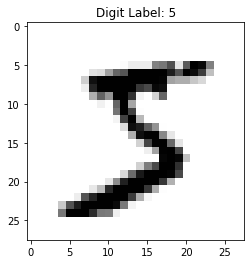

In [3]:
import matplotlib.pyplot as plt
from utils import (MnistDataset)
import numpy as np
md = MnistDataset()
X_train, y_train = md.train_dataset()
X_test, y_test = md.test_dataset()

first_image = X_train[0,:]
first_label = y_train[0]

# 784 columns correspond to 28x28 image
plottable_image = np.reshape(first_image, (28, 28))
# Plot the image
plt.imshow(plottable_image, cmap='gray_r')
plt.title('Digit Label: {}'.format(first_label))

plt.show()

Let's try the voted perceptron algorithm

In [ ]:
# build the gram matrix
import numpy as np
from numba import njit 
@njit
def build_gram():
  Gram = np.zeros((60000,60000), dtype=np.float32)
  for i in range(Gram.shape[0]):
    for j in range(i,Gram.shape[0]):
        Gram[i,j] = 2
        Gram[j,i] = 2
  return Gram
Gram = build_gram()
%reset Gram